In [21]:
import helper_functions
import numpy as np
import sklearn
#Import keras from tensorflow and not as a standalone thing (that makes things work weird idk why)
from tensorflow import keras
# CNN
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv1D, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import InputLayer, Dropout, LSTM, BatchNormalization, Flatten, ZeroPadding1D, AveragePooling2D, BatchNormalization, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pickle
#import helper_functions
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout, BatchNormalization


from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

In [2]:
data_path = 'data'
with open(data_path, 'rb') as f:
    data = pickle.Unpickler(f).load()

In [3]:
# Shuffle the data
dataToShuffle = []

for log, mfcc, label in zip(data['log-mel'],data['mfccs'],data['classes']):
    dataToShuffle.append([log,mfcc,label])

ShuffledData = np.array(dataToShuffle)
np.random.shuffle(ShuffledData)

In [4]:
# Separate the data into training and test datasets
Train = ShuffledData[:45305]
Test = ShuffledData[45305:]

log_train = []
mfcc_train = []
y_train = []

log_test = []
mfcc_test = []
y_test = []

for log, mfcc, label in Train:
    log_train.append(log)
    mfcc_train.append(mfcc)
    y_train.append(label)
    
for log, mfcc, label in Test:
    log_test.append(log)
    mfcc_test.append(mfcc)
    y_test.append(label)


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

for i in range(2):
    label = y_train[45000+i]
    plt.figure()
    plt.title("Class id: "+ str(label))
    plt.imshow(x_train[45000+i])

In [56]:
log_test[0].shape


(15, 173)

In [13]:
InputShape = log_test[0].shape
output_dim = y_test[0].shape[0]

dropout = 0.2

#based on model 1 from https://www.researchgate.net/publication/348432098_Speech_recognition_based_on_Convolutional_neural_networks_and_MFCC_algorithm
# Getting around 80% accuracy
model = Sequential()

model.add(InputLayer(input_shape=InputShape))
model.add(ZeroPadding1D(padding=2))

model.add(Conv1D(filters=256, kernel_size=10))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(output_dim))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Import new metrics 
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', recall, precision])

In [14]:
# Initiate early stopping callback (on validation set from training data 0.15)
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 3)
#Train the model 
x_train = np.array(mfcc_train)
y_train = np.array(y_train)
history = model.fit(x=x_train, y=y_train, epochs=12, batch_size=128, validation_split = 0.10, callbacks = [callback])

Epoch 1/12
319/319 [==============================] - 16s 44ms/step - loss: 26.6607 - accuracy: 0.5008 - recall: 0.5004 - precision: 0.5014 - val_loss: 8.4323 - val_accuracy: 0.4745 - val_recall: 0.4723 - val_precision: 0.4769
Epoch 2/12
319/319 [==============================] - 14s 45ms/step - loss: 6.8520 - accuracy: 0.6055 - recall: 0.6046 - precision: 0.6076 - val_loss: 3.7961 - val_accuracy: 0.6820 - val_recall: 0.6800 - val_precision: 0.6847
Epoch 3/12
319/319 [==============================] - 17s 53ms/step - loss: 4.6382 - accuracy: 0.6587 - recall: 0.6571 - precision: 0.6611 - val_loss: 4.4126 - val_accuracy: 0.7248 - val_recall: 0.7243 - val_precision: 0.7259
Epoch 4/12
319/319 [==============================] - 14s 45ms/step - loss: 3.7345 - accuracy: 0.6965 - recall: 0.6951 - precision: 0.6992 - val_loss: 3.5750 - val_accuracy: 0.6241 - val_recall: 0.6208 - val_precision: 0.6303
Epoch 5/12
319/319 [==============================] - 14s 44ms/step - loss: 3.0992 - accuracy: 

In [15]:
# Save the model 
model.save('models\CNN')

# Save history object
file = open('models\CNN_history', 'wb')
pickle.dump(history.history,file)
file.close()

INFO:tensorflow:Assets written to: models\CNN\assets


In [16]:
# Load the model 
model = keras.models.load_model('models\CNN')


# Load the history object 
file = open('models\CNN_history', 'rb')
history = pickle.load(file)
file.close()

In [17]:
# Testing the model 1
x_test = np.array(mfcc_test)
y_test = np.array(y_test)
score = model.evaluate(x_test,y_test)

607/607 [==============================] - 3s 4ms/step - loss: 2.6707 - accuracy: 0.7811 - recall: 0.7803 - precision: 0.7826


In [18]:
# Model's prediction on the test data and the desired output
output = model.predict(x_test)
logits_pred = output.argmax(axis=1)
logits_test = y_test.argmax(axis=1)

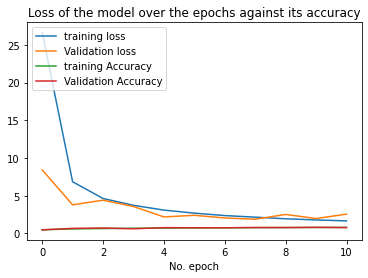

In [19]:
# Training/Validation Loss
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.plot(history['accuracy'], label="training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.title('Loss of the model over the epochs against its accuracy')

plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

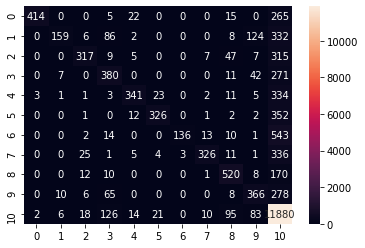

In [22]:
# Confusion matrix
cf_matrix = confusion_matrix(logits_test,logits_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g' )

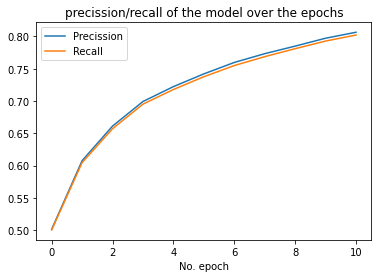

In [26]:
# Precision / Recall curve (training)
plt.plot(history['precision'], label="Precission")
plt.plot(history['recall'], label="Recall")
plt.title('precission/recall of the model over the epochs')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [50]:
#based on https://towardsdatascience.com/tensorflow-speech-recognition-challenge-solution-outline-9c42dbd219c9
#this one could be quite good, ^^ was getting like 80-85% accuracy (It's the 1D CNN)
#was getting barely over 60% but made the model less deep (as can be seen by comments) and it got much better ~75%->more epochs = 81%
model2 = Sequential()

model2.add(BatchNormalization())

model2.add(Conv1D(64,kernel_size=2,padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(64,kernel_size=2,padding='same'))
model2.add(Activation('relu'))

model2.add(Dropout(0.2))

model2.add(Conv1D(128, 3,padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(128, 3,padding='same'))
model2.add(Activation('relu'))


model2.add(Dropout(0.2))
model2.add(MaxPooling1D(2))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(12, activation="softmax"))
    

In [51]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])

In [52]:
#Train the model (this was 25 epochs)
x_train = np.array(mfcc_train)
y_train = np.array(y_train)
history2 = model2.fit(x=x_train, y=y_train, epochs=15, batch_size=64)

Epoch 1/15
708/708 [==============================] - 13s 16ms/step - loss: 1.4507 - accuracy: 0.6312 - precision: 0.7367 - recall: 0.6163
Epoch 2/15
708/708 [==============================] - 12s 16ms/step - loss: 1.2954 - accuracy: 0.6388 - precision: 0.7013 - recall: 0.5498
Epoch 3/15
708/708 [==============================] - 12s 16ms/step - loss: 1.1632 - accuracy: 0.6535 - precision: 0.7305 - recall: 0.5495
Epoch 4/15
708/708 [==============================] - 11s 16ms/step - loss: 1.0570 - accuracy: 0.6758 - precision: 0.7586 - recall: 0.5711
Epoch 5/15
708/708 [==============================] - 12s 17ms/step - loss: 0.9815 - accuracy: 0.6910 - precision: 0.7731 - recall: 0.5904
Epoch 6/15
708/708 [==============================] - 12s 17ms/step - loss: 0.9214 - accuracy: 0.7070 - precision: 0.7854 - recall: 0.6127
Epoch 7/15
708/708 [==============================] - 12s 17ms/step - loss: 0.8813 - accuracy: 0.7187 - precision: 0.7930 - recall: 0.6286
Epoch 8/15
708/708 [=======

In [53]:
# Save the model 2
model2.save('models\CNN2')

# Save history object
file = open('models\CNN2_history', 'wb')
pickle.dump(history2.history,file)
file.close()

INFO:tensorflow:Assets written to: models\CNN2\assets


In [54]:
# Load the model 
model2 = keras.models.load_model('models\CNN')


# Load the history object 
file = open('models\CNN2_history', 'rb')
history2 = pickle.load(file)
file.close()

In [55]:
# Testing the model 2
x_test = np.array(mfcc_test)
y_test = np.array(y_test)
score = model2.evaluate(x_test,y_test)

607/607 [==============================] - 3s 4ms/step - loss: 2.6707 - accuracy: 0.7811 - recall: 0.7803 - precision: 0.7826


In [56]:

# Model1's prediction on the test data and the desired output
output2 = model2.predict(x_test)
logits_pred2 = output2.argmax(axis=1)
logits_test2 = y_test.argmax(axis=1)

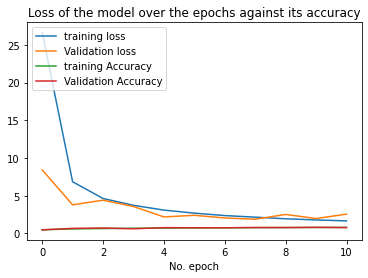

In [57]:

# Training/Validation Loss
plt.plot(history2['loss'], label="training loss")
plt.plot(history2['val_loss'], label="Validation loss")
plt.plot(history2['accuracy'], label="training Accuracy")
plt.plot(history2['val_accuracy'], label="Validation Accuracy")
plt.title('Loss of the model over the epochs against its accuracy')

plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

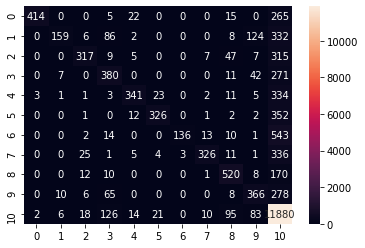

In [58]:
# Confusion matrix
cf_matrix = confusion_matrix(logits_test2,logits_pred2)
sns.heatmap(cf_matrix, annot=True, fmt='g' )

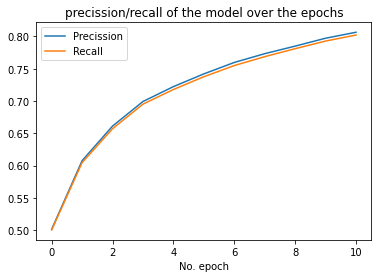

In [59]:
# Precision / Recall curve (training)
plt.plot(history2['precision'], label="Precission")
plt.plot(history2['recall'], label="Recall")
plt.title('precission/recall of the model over the epochs')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()